In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [4]:
from train import setup_cfg, print_args
import argparse
from dassl.utils import setup_logger, set_random_seed, collect_env_info
from dassl.engine import build_trainer
import torch
from notebooks.utils import viz_tensors
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--root', type=str, default='data', help='path to dataset')
parser.add_argument(
    '--output-dir', type=str, default='output', help='output directory'
)
parser.add_argument(
    '--resume',
    type=str,
    default='',
    help='checkpoint directory (from which the training resumes)'
)
parser.add_argument(
    '--seed',
    type=int,
    default=-1,
    help='only positive value enables a fixed seed'
)
parser.add_argument(
    '--source-domains',
    type=str,
    default=['mnist'],
    nargs='+',
    help='source domains for DA/DG'
)
parser.add_argument(
    '--target-domains',
    type=str,
    default=['svhn'],
    nargs='+',
    help='target domains for DA/DG'
)
parser.add_argument(
    '--transforms', type=str, nargs='+', help='data augmentation methods'
)
parser.add_argument(
    '--config-file', type=str, default='configs/trainers/digit5.yaml', help='path to config file'
)
parser.add_argument(
    '--dataset-config-file',
    type=str,
    default='configs/datasets/digit5.yaml',
    help='path to config file for dataset setup'
)
parser.add_argument(
    '--trainer', type=str, default='AdaMatch', help='name of trainer'
)
parser.add_argument(
    '--backbone', type=str, default='', help='name of CNN backbone'
)
parser.add_argument('--head', type=str, default='', help='name of head')
parser.add_argument(
    '--eval-only', action='store_true', help='evaluation only'
)
parser.add_argument(
    '--model-dir',
    type=str,
    default='',
    help='load model from this directory for eval-only mode'
)
parser.add_argument(
    '--load-epoch',
    type=int,
    help='load model weights at this epoch for evaluation'
)
parser.add_argument(
    '--no-train', action='store_true', help='do not call trainer.train()'
)
parser.add_argument(
    'opts',
    default=None,
    nargs=argparse.REMAINDER,
    help='modify config options using the command-line'
)
sys.argv = ['-f']
args = parser.parse_args()

In [5]:
args

Namespace(backbone='', config_file='configs/trainers/digit5.yaml', dataset_config_file='configs/datasets/digit5.yaml', eval_only=False, head='', load_epoch=None, model_dir='', no_train=False, opts=[], output_dir='output', resume='', root='data', seed=-1, source_domains=['mnist'], target_domains=['svhn'], trainer='AdaMatch', transforms=None)

In [6]:
cfg = setup_cfg(args)
if cfg.SEED >= 0:
    print('Setting fixed seed: {}'.format(cfg.SEED))
    set_random_seed(cfg.SEED)
setup_logger(cfg.OUTPUT_DIR)

if torch.cuda.is_available() and cfg.USE_CUDA:
    torch.backends.cudnn.benchmark = True

print_args(args, cfg)
print('Collecting env info ...')
print('** System info **\n{}\n'.format(collect_env_info()))

trainer = build_trainer(cfg)

***************
** Arguments **
***************
backbone: 
config_file: configs/trainers/digit5.yaml
dataset_config_file: configs/datasets/digit5.yaml
eval_only: False
head: 
load_epoch: None
model_dir: 
no_train: False
opts: []
output_dir: output
resume: 
root: data
seed: -1
source_domains: ['mnist']
target_domains: ['svhn']
trainer: AdaMatch
transforms: None
************
** Config **
************
DATALOADER:
  K_TRANSFORMS: 1
  NUM_WORKERS: 4
  TEST:
    BATCH_SIZE: 500
    SAMPLER: SequentialSampler
  TRAIN_U:
    BATCH_SIZE: 192
    N_DOMAIN: 0
    N_INS: 16
    SAME_AS_X: False
    SAMPLER: RandomSampler
  TRAIN_X:
    BATCH_SIZE: 64
    N_DOMAIN: 0
    N_INS: 16
    SAMPLER: RandomSampler
DATASET:
  ALL_AS_UNLABELED: False
  CIFAR_C_LEVEL: 1
  CIFAR_C_TYPE: 
  NAME: Digit5
  NUM_LABELED: 250
  ROOT: data
  SOURCE_DOMAINS: ['mnist']
  STL10_FOLD: -1
  TARGET_DOMAINS: ['svhn']
  VAL_PERCENT: 0.1
INPUT:
  COLORJITTER_B: 0.4
  COLORJITTER_C: 0.4
  COLORJITTER_H: 0.1
  COLORJITTER_S: 

In [7]:
trainer.max_iter

260

In [7]:
trainer.test_loader

In [ ]:
batch_x = next(iter(trainer.train_loader_x))
batch_u = next(iter(trainer.train_loader_u))
batch_test = next(iter(trainer.test_loader))

In [9]:
batch_x.keys()

dict_keys(['label', 'domain', 'impath', 'img', 'img2', 'img0'])

In [10]:
batch_u.keys()

dict_keys(['label', 'domain', 'impath', 'img', 'img2', 'img0'])

In [29]:
input_x, input_x2, label_x, input_u, input_u2, label_u = \
    trainer.parse_batch_train(batch_x, batch_u)
input_test, label_test = trainer.parse_batch_test(batch_test)

In [12]:
input_x.shape, input_x2.shape, label_x.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [13]:
input_u.shape, input_u2.shape, label_u.shape

(torch.Size([192, 3, 32, 32]), torch.Size([192, 3, 32, 32]), torch.Size([192]))

In [20]:
mean = trainer.cfg.INPUT.PIXEL_MEAN
std = trainer.cfg.INPUT.PIXEL_STD

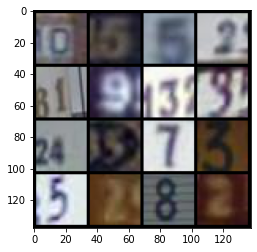

In [30]:
grid = viz_tensors(input_test, mean=mean, std=std)

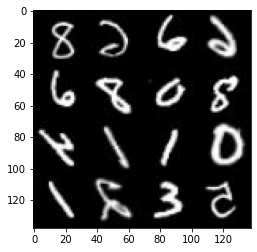

In [22]:
grid = viz_tensors(input_x, mean=mean, std=std)

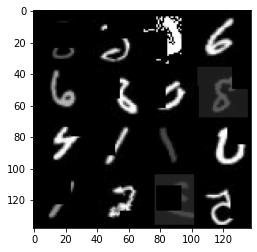

In [23]:
grid = viz_tensors(input_x2, mean=mean, std=std)

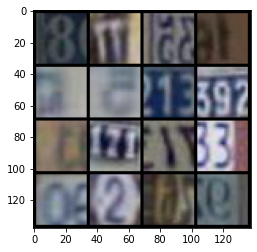

In [24]:
grid = viz_tensors(input_u, mean=mean, std=std)

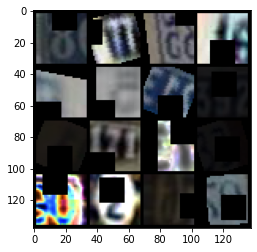

In [25]:
grid = viz_tensors(input_u2, mean=mean, std=std)

In [ ]:
from train import cfg_to_dict

In [27]:
cfg_to_dict(trainer.cfg)

{'VERSION': 1,
 'OUTPUT_DIR': 'output',
 'RESUME': '',
 'SEED': -1,
 'USE_CUDA': True,
 'VERBOSE': True,
 'INPUT': {'SIZE': (32, 32),
  'TRANSFORMS': ('random_flip', 'random_translation', 'normalize'),
  'NO_TRANSFORM': False,
  'PIXEL_MEAN': [0.5, 0.5, 0.5],
  'PIXEL_STD': [0.5, 0.5, 0.5],
  'CROP_PADDING': 4,
  'CUTOUT_N': 1,
  'CUTOUT_LEN': 16,
  'GN_MEAN': 0.0,
  'GN_STD': 0.15,
  'RANDAUGMENT_N': 2,
  'RANDAUGMENT_M': 10,
  'COLORJITTER_B': 0.4,
  'COLORJITTER_C': 0.4,
  'COLORJITTER_S': 0.4,
  'COLORJITTER_H': 0.1,
  'RGS_P': 0.2,
  'GB_P': 0.5,
  'GB_K': 21},
 'DATASET': {'ROOT': 'data',
  'NAME': 'Digit5',
  'SOURCE_DOMAINS': ['mnist'],
  'TARGET_DOMAINS': ['svhn'],
  'NUM_LABELED': 250,
  'VAL_PERCENT': 0.1,
  'STL10_FOLD': -1,
  'CIFAR_C_TYPE': '',
  'CIFAR_C_LEVEL': 1,
  'ALL_AS_UNLABELED': False},
 'DATALOADER': {'NUM_WORKERS': 4,
  'K_TRANSFORMS': 1,
  'TRAIN_X': {'SAMPLER': 'RandomSampler',
   'BATCH_SIZE': 64,
   'N_DOMAIN': 0,
   'N_INS': 16},
  'TRAIN_U': {'SAME_AS_X':

In [33]:
25_000 / 192

130.20833333333334

In [32]:
trainer.max_iter

260

In [ ]:
x = np.arange(trainer.max_iter)
y = np.vectorize(trainer._compute_loss_target_weight)(x, trainer.max_iter * 2)

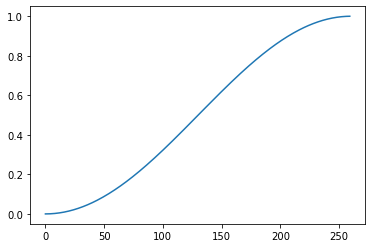

In [41]:
plt.plot(x, y)

In [8]:
trainer._compute_loss_target_weight(130, 260)

[autoreload of trainers.adamatch failed: Traceback (most recent call last):
  File "/Users/angyizhe/opt/miniconda3/envs/dassl/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/angyizhe/opt/miniconda3/envs/dassl/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/angyizhe/opt/miniconda3/envs/dassl/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/angyizhe/opt/miniconda3/envs/dassl/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/angyizhe/code/SLAB/AdaMatch-PyTorch/trainers/adamatch.py", line 18, in <module>
  

1.0